# Policy
In reinforcement learning, the agent interacts with environments to improve itself. In this tutorial we will concentrate on the agent part. In Tianshou, both the agent and the core DRL algorithm are implementated in the Policy module. Tianshou provides more than 20 Policy modules, each representing one DRL algorithm. See supported algorithms [here](https://github.com/thu-ml/tianshou).

<div align=center>
<img src="https://tianshou.readthedocs.io/en/master/_images/rl-loop.jpg", title="The agents interacting with the environment">

<a> The agents interacting with the environment </a>
</div>

All Policy modules inherit from a BasePolicy Class and share the same interface.

# Creating your own Policy
We will use the simple REINFORCE algorithm Policy to show the implementation of a Policy Module. The Policy we implement here will be a highly scaled-down version of [PGPolicy](https://github.com/thu-ml/tianshou/blob/master/tianshou/policy/modelfree/pg.py) in Tianshou.

## Initialisation
Firstly we create the `REINFORCEPolicy` by inheriting from `BasePolicy` in Tianshou.

In [ ]:
from typing import Dict, List

import numpy as np
import torch
import gymnasium as gym

from tianshou.data import Batch, ReplayBuffer, to_torch, to_torch_as
from tianshou.policy import BasePolicy
from tianshou.utils.net.common import Net
from tianshou.utils.net.discrete import Actor

In [ ]:
class REINFORCEPolicy(BasePolicy):
    """Implementation of REINFORCE algorithm."""

    def __init__(self):
        super().__init__(action_space=action_space)

As we have mentioned, the Policy Module mainly does two things:


1.   `policy.forward()` receives observation and other information (stored in a Batch) from the environment and returns a new Batch containing the action.
2.   `policy.update()` receives training data sampled from the replay buffer and updates itself, and then returns logging details.


<div align=center>
<img src="https://tianshou.readthedocs.io/en/master/_images/pipeline.png" width="400">

<a> policy.forward() and policy.update() </a>
</div>

We also need to take care of the following things:



1.   Since Tianshou is a **Deep** RL libraries, there should be a policy network in our Policy Module, also a Torch optimizer.
2.   In Tianshou's BasePolicy, `Policy.update()` first calls `Policy.process_fn()` to preprocess training data and computes quantities like episodic returns (gradient free), then it will call `Policy.learn()` to perform the back-propagation.

Then we get the implementation below.





In [ ]:
class REINFORCEPolicy(BasePolicy):
    """Implementation of REINFORCE algorithm."""

    def __init__(
        self, model: torch.nn.Module, optim: torch.optim.Optimizer, action_space: gym.Space
    ):
        super().__init__(action_space=action_space)
        self.actor = model
        self.optim = optim

    def forward(self, batch: Batch) -> Batch:
        """Compute action over the given batch data."""
        act = None
        return Batch(act=act)

    def process_fn(self, batch: Batch, buffer: ReplayBuffer, indices: np.ndarray) -> Batch:
        """Compute the discounted returns for each transition."""
        pass

    def learn(self, batch: Batch, batch_size: int, repeat: int) -> Dict[str, List[float]]:
        """Perform the back-propagation."""
        return

## Policy.forward()
According to the equation of REINFORCE algorithm in Spinning Up's [documentation](https://spinningup.openai.com/en/latest/algorithms/vpg.html), we need to map the observation to an action distribution in action space using neural network (`self.actor`).

<div align=center>
<img src="https://spinningup.openai.com/en/latest/_images/math/3d29a18c0f98b1cdb656ecdf261ee37ffe8bb74b.svg" width="400">
</div>

Let us suppose the action space is discrete, and the distribution is a simple categorical distribution.



In [ ]:
def forward(self, batch: Batch) -> Batch:
    """Compute action over the given batch data."""
    self.dist_fn = torch.distributions.Categorical
    logits = self.actor(batch.obs)
    dist = self.dist_fn(logits)
    act = dist.sample()
    return Batch(act=act, dist=dist)

## Policy.process_fn()
Now that we have defined our actor, if given training data we can set up a loss function and optimize our neural network. However, before that, we must first calculate episodic returns for every step in our training data to construct the REINFORCE loss function.

Calculating episodic return is not hard, given `ReplayBuffer.next()` allows us to access every reward to go in an episode. A more convenient way would be to simply use the built-in method `BasePolicy.compute_episodic_return()` inherited from BasePolicy.


In [ ]:
def process_fn(self, batch: Batch, buffer: ReplayBuffer, indices: np.ndarray) -> Batch:
    """Compute the discounted returns for each transition."""
    returns, _ = self.compute_episodic_return(batch, buffer, indices, gamma=0.99, gae_lambda=1.0)
    batch.returns = returns
    return batch

`BasePolicy.compute_episodic_return()` could also be used to compute [GAE](https://arxiv.org/abs/1506.02438). Another similar method is `BasePolicy.compute_nstep_return()`. Check the [source code](https://github.com/thu-ml/tianshou/blob/6fc68578127387522424460790cbcb32a2bd43c4/tianshou/policy/base.py#L304) for more details.

## Policy.learn()
Data batch returned by `Policy.process_fn()` will flow into `Policy.learn()`. Finall we can construct our loss function and perform the back-propagation.

In [ ]:
def learn(self, batch: Batch, batch_size: int, repeat: int) -> Dict[str, List[float]]:
    """Perform the back-propagation."""
    logging_losses = []
    for _ in range(repeat):
        for minibatch in batch.split(batch_size, merge_last=True):
            self.optim.zero_grad()
            result = self(minibatch)
            dist = result.dist
            act = to_torch_as(minibatch.act, result.act)
            ret = to_torch(minibatch.returns, torch.float, result.act.device)
            log_prob = dist.log_prob(act).reshape(len(ret), -1).transpose(0, 1)
            loss = -(log_prob * ret).mean()
            loss.backward()
            self.optim.step()
            logging_losses.append(loss.item())
    return {"loss": logging_losses}

## Implementation
Finally we can assemble the implemented methods and form a REINFORCE Policy.

In [ ]:
class REINFORCEPolicy(BasePolicy):
    """Implementation of REINFORCE algorithm."""

    def __init__(
        self,
        *,
        model: torch.nn.Module,
        optim: torch.optim.Optimizer,
        action_space: gym.Space,
    ):
        super().__init__(action_space=action_space)
        self.actor = model
        self.optim = optim
        # action distribution
        self.dist_fn = torch.distributions.Categorical

    def forward(self, batch: Batch) -> Batch:
        """Compute action over the given batch data."""
        logits, _ = self.actor(batch.obs)
        dist = self.dist_fn(logits)
        act = dist.sample()
        return Batch(act=act, dist=dist)

    def process_fn(self, batch: Batch, buffer: ReplayBuffer, indices: np.ndarray) -> Batch:
        """Compute the discounted returns for each transition."""
        returns, _ = self.compute_episodic_return(
            batch, buffer, indices, gamma=0.99, gae_lambda=1.0
        )
        batch.returns = returns
        return batch

    def learn(self, batch: Batch, batch_size: int, repeat: int) -> Dict[str, List[float]]:
        """Perform the back-propagation."""
        logging_losses = []
        for _ in range(repeat):
            for minibatch in batch.split(batch_size, merge_last=True):
                self.optim.zero_grad()
                result = self(minibatch)
                dist = result.dist
                act = to_torch_as(minibatch.act, result.act)
                ret = to_torch(minibatch.returns, torch.float, result.act.device)
                log_prob = dist.log_prob(act).reshape(len(ret), -1).transpose(0, 1)
                loss = -(log_prob * ret).mean()
                loss.backward()
                self.optim.step()
                logging_losses.append(loss.item())
        return {"loss": logging_losses}

# Use the policy
Note that `BasePolicy` itself inherits from `torch.nn.Module`. As a result, you can consider all Policy modules as a Torch Module. They share similar APIs.

Firstly we will initialise a new REINFORCE policy.

In [ ]:
state_shape = 4
action_shape = 2
# Usually taken from an env by using env.action_space
action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
net = Net(state_shape, hidden_sizes=[16, 16], device="cpu")
actor = Actor(net, action_shape, device="cpu").to("cpu")
optim = torch.optim.Adam(actor.parameters(), lr=0.0003)

policy = REINFORCEPolicy(model=actor, optim=optim, action_space=action_space)

REINFORCE policy shares same APIs with the Torch Module.

In [ ]:
print(policy)
print("========================================")
for para in policy.parameters():
    print(para.shape)

## Making decision
Given a batch of observations, the policy can return a batch of actions and other data.

In [ ]:
obs_batch = Batch(obs=np.ones(shape=(256, 4)))
action = policy(obs_batch)  # forward() method is called
print(action)

## Save and Load models
Naturally, Tianshou Policy can be saved and loaded like a normal Torch Network.

In [ ]:
torch.save(policy.state_dict(), "policy.pth")
assert policy.load_state_dict(torch.load("policy.pth"))

## Algorithm Updating
We have to collect some data and save them in the ReplayBuffer before updating our agent(policy). Typically we use collector to collect data, but we leave this part till later when we have learned the Collector in Tianshou. For now we generate some **fake** data.

### Generating fake data
Firstly, we need to "pretend" that we are using the "Policy" to collect data. We plan to collect 10 data so that we can update our algorithm.

In [ ]:
# a buffer is initialised with its maxsize set to 20.
print("========================================")
buf = ReplayBuffer(size=12)
print(buf)
print("maxsize: {}, data length: {}".format(buf.maxsize, len(buf)))
env = gym.make("CartPole-v1")

Now we are pretending to collect the first episode. The first episode ends at step 3 (perhaps because we are performing too badly).

In [ ]:
obs, info = env.reset()
for i in range(3):
    act = policy(Batch(obs=obs[np.newaxis, :])).act.item()
    obs_next, rew, _, truncated, info = env.step(act)
    # pretend ending at step 3
    terminated = True if i == 2 else False
    info["id"] = i
    buf.add(
        Batch(
            obs=obs,
            act=act,
            rew=rew,
            terminated=terminated,
            truncated=truncated,
            obs_next=obs_next,
            info=info,
        )
    )
    obs = obs_next

In [ ]:
print(buf)

Now we are pretending to collect the second episode. At step 7 the second episode still does't end, but we are unwilling to wait, so we stop collecting to update the algorithm.

In [ ]:
obs, info = env.reset()
for i in range(3, 10):
    act = policy(Batch(obs=obs[np.newaxis, :])).act.item()
    obs_next, rew, _, truncated, info = env.step(act)
    # pretend this episode never end
    terminated = False
    info["id"] = i
    buf.add(
        Batch(
            obs=obs,
            act=act,
            rew=rew,
            terminated=terminated,
            truncated=truncated,
            obs_next=obs_next,
            info=info,
        )
    )
    obs = obs_next

Our replay buffer looks like this now.

In [ ]:
print(buf)
print("maxsize: {}, data length: {}".format(buf.maxsize, len(buf)))

### Updates
Now we have got a replay buffer with 10 data steps in it. We can call `Policy.update()` to train.

In [ ]:
# 0 means sample all data from the buffer
# batch_size=10 defines the training batch size
# repeat=6 means repeat the training for 6 times
policy.update(0, buf, batch_size=10, repeat=6)

Not that difficult, right?

# Further Reading




## Pre-defined Networks
Tianshou provides numberous pre-defined networks usually used in DRL so that you don't have to bother yourself. Check this [documentation](https://tianshou.readthedocs.io/en/master/api/tianshou.utils.html#pre-defined-networks) for details.

## How to compute GAE on your own?
(Note that for this reading you need to understand the calculation of [GAE](https://arxiv.org/abs/1506.02438) advantage first)

In terms of code implementation, perhaps the most difficult and annoying part is computing GAE advantage. Just now, we use the `self.compute_episodic_return()` method inherited from `BasePolicy` to save us from all those troubles. However, it is still important that we know the details behind this.

To compute GAE advantage, the usage of `self.compute_episodic_return()` may go like:

In [ ]:
batch, indices = buf.sample(0)  # 0 means sampling all the data from the buffer
returns, advantage = BasePolicy.compute_episodic_return(
    batch, buf, indices, v_s_=np.zeros(10), v_s=np.zeros(10), gamma=1.0, gae_lambda=1.0
)
print(returns)
print(advantage)

In the code above, we sample all the 10 data in the buffer and try to compute the GAE advantage. As we know, we need to estimate the value function of every observation to compute GAE advantage. so the passed in `v_s` is the value of bacth.obs, `v_s_` is the value of bacth.obs_next this is usually computed by:

`v_s = critic(bacth.obs)`,

`v_s_ = critic(bacth.obs_next)`,

where uboth `v_s` and `v_s_` are 10 dimensional arrays and `critic` is usually a neural network.

After we've got all those values, GAE can be computed following the equation below.

\begin{aligned}
\hat{A}_{t}^{\mathrm{GAE}(\gamma, \lambda)}: =& \sum_{l=0}^{\infty}(\gamma \lambda)^{l} \delta_{t+l}^{V}
\end{aligned}

while

\begin{equation}
\delta_{t}^{V} \quad=-V\left(s_{t}\right)+r_{t}+\gamma V\left(s_{t+1}\right)
\end{equation}


But, if you do follow this equation I refered from the paper. You probably will get a slightly lower performance than you expected. There are at least 3 "bugs" in this equation.

**First** is that Gym always returns you a `obs_next` even if this is already the last step. The value of this timestep is exactly 0 and you should not let the neural network estimate it.

In [ ]:
# Assume v_s_ is got by calling critic(bacth.obs_next)
v_s_ = np.ones(10)
v_s_ *= ~batch.done
print(v_s_)

After the fix above, we will perhaps get a more accurate estimate.

**Secondly**, you must know when to stop bootstrapping. Usually we stop bootstrapping when we meet a `done` flag. However, in the buffer above, the last (10th) step is not marked by done=True, because the collecting has not finished. We must know all those unfinished steps so that we know when to stop bootstraping.

Luckily, this can be done under the assistance of buffer because buffers in Tianshou not only store data, but also help you manage data trajectories.

In [ ]:
unfinished_indexes = buf.unfinished_index()
print(unfinished_indexes)
done_indexes = np.where(batch.done)[0]
print(done_indexes)
stop_bootstrap_ids = np.concatenate([unfinished_indexes, done_indexes])
print(stop_bootstrap_ids)

**Thirdly**, there are some special indexes which are marked by done flag. However, its value for obs_next should not be zero. This is because these steps are usually those at the last step of an episode, but this episode stops not because the agent can no longer get any rewards (value=0), but because the episode is too long so we have to truncate it. These kind of steps are always marked with `info['TimeLimit.truncated']=True` in Gym.

As a result, we need to rewrite the equation above

`v_s_ *= ~batch.done`

to

```
mask = batch.info['TimeLimit.truncated'] | (~batch.done)
v_s_ *= mask

```





### Summary
If you already felt bored by now, simply remember that Tianshou can help handle all these little details so that you can focus on the algorithm itself. Just call `BasePolicy.compute_episodic_return()`.

If you still feel interested, we would recommend you check Appendix C in this [paper](https://arxiv.org/abs/2107.14171v2) and implementation of `BasePolicy.value_mask()` and `BasePolicy.compute_episodic_return()` for details.


timelimit.svg

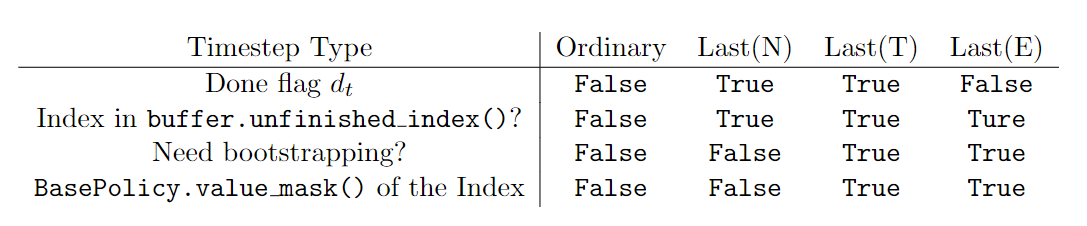